In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import time
import datetime
from sklearn.metrics import roc_auc_score
from scipy import sparse

In [2]:
#加载训练集，测试集
train_x = pd.read_csv('../data/train_x.csv', index_col = False)
train_xy = pd.read_csv('../data/train_xy.csv', index_col = False)
test_df = pd.read_csv('../data/test_all.csv', index_col = False)
#合并训练集测试集，标记test_df和train_x不同的y用来区分
test_df['y'] = -1
train_x['y'] = -2
data = pd.concat((train_xy, test_df), axis = 0)
data = pd.concat((data, train_x), axis = 0)
print(data.head())

  cust_group  cust_id       x_1  x_10  x_100  x_101  x_102  x_103  x_104  \
0    group_3   110000  0.354167   -99      1      1    -99    -99    -99   
1    group_3   110001  0.125000   -99      1      1    -99    -99    -99   
2    group_3   110002  0.333333     0      1      1    -99    -99    -99   
3    group_3   110003  0.208333     0      1      1    -99    -99    -99   
4    group_3   110004  0.208333     1      1      1    -99    -99    -99   

   x_105 ...  x_91  x_92       x_93  x_94      x_95  x_96  x_97  x_98  x_99  y  
0    -99 ...     1 -99.0   0.208333   -99  0.436170     2     2     2     1  0  
1    -99 ...     1 -99.0   0.270833   -99  0.297872     1     2     1     1  0  
2    -99 ...     1 -99.0 -99.000000   -99  0.372340     1     1     1     1  0  
3    -99 ...     1 -99.0   0.010417   -99  0.053191     1     2     2     1  0  
4    -99 ...     1 -99.0   0.052083   -99  0.095745     2     1     1     1  0  

[5 rows x 160 columns]


In [3]:
#不同的客户群体，填充方式不能一概而论，分开填充
def process(data):
    no_data_ratio_1 = set([])
    data_part = data.copy()
    for group in [['group_1','group_2','group_3']]:#[['group_1'], ['group_2'], ['group_3']]:
        print('进行到', group)
        data = data_part[data_part.cust_group.isin(group)].copy()
        count = 0
        col = 0
        col_more_none = []
        col_less_none = []
        no_none = []
        for i in data.columns:
            col += 1
            if i not in ['cust_id', 'cust_group', 'y'] and sum(data[i] == -99):
                print(i,'有缺失值比例和缺失值：', (sum(data[i] == -99) / data.shape[0], sum(data[i] == -99)))
                count += 1
                if(sum(data[i] == -99) / data.shape[0] > 0.99):
                    no_data_ratio_1.add(i)
                if(sum(data[i] == -99) / data.shape[0] > 0.99):
                    col_more_none.append(i)
                if(sum(data[i] == -99) / data.shape[0] < 0.09):
                    col_less_none.append(i)
                if col >= 96:
                    col_more_none.append(i)
            elif i not in ['cust_id', 'cust_group', 'y']:
                no_none.append(i)
        print('总的缺失值：', count)
        
        lbl = LabelEncoder()
        data.loc[data[i] == -99, i] = data[i].mode()[0]

        for i in range(96, 158):
            data['x_'+str(i)] = lbl.fit_transform(data['x_'+str(i)])
            
        count = 0
        final = []
        for i in data.columns:
            if i not in ['cust_id', 'cust_group'] and sum(data[i] == -99):
                print(i,'有缺失值比例和缺失值：', (sum(data[i] == -99) / data.shape[0], sum(data[i] == -99)))
                count += 1
                final.append(i)
        print('总的缺失值：', count)
        
        for i in ['x_12', 'x_18', 'x_23', 'x_28', 'x_34', 'x_6']:#单独用Lbl做
            data[i] = lbl.fit_transform(data[i])
            
        
        #final用均值填充
        for i in final:
        #     del data[i]
#             if data[i].nunique()
#             data.loc[data[i] == -99, i] = data[i].mode()[0]
            data.loc[data[i]==-99, i] = np.median(data.loc[data[i]!=-99, i])
        
        count = 0
        for i in data.columns:
            if i not in ['cust_id', 'cust_group'] and sum(data[i] == -99):
                print(i,'有缺失值比例和缺失值：', (sum(data[i] == -99) / data.shape[0], sum(data[i] == -99)))
                count += 1
        print('最后还有缺失值：', count)
        
        data_part.loc[data_part.cust_group.isin(group)] = data
    
    count = 0
    for i in data_part.columns:
        if i not in ['cust_id', 'cust_group'] and sum(data_part[i] == -99):
            print(i,'有缺失值比例和缺失值：', (sum(data_part[i] == -99) / data_part.shape[0], sum(data_part[i] == -99)))
            count += 1
    print('最后还有缺失值：', count)
        
    return data_part, no_data_ratio_1

In [4]:
data, no_data_ratio_1 = process(data)

进行到 ['group_1', 'group_2', 'group_3']
x_10 有缺失值比例和缺失值： (0.4665142857142857, 16328)
x_100 有缺失值比例和缺失值： (0.0118, 413)
x_101 有缺失值比例和缺失值： (0.0118, 413)
x_102 有缺失值比例和缺失值： (0.9998857142857143, 34996)
x_103 有缺失值比例和缺失值： (0.9996571428571429, 34988)
x_104 有缺失值比例和缺失值： (0.9990857142857142, 34968)
x_105 有缺失值比例和缺失值： (0.9980571428571429, 34932)
x_106 有缺失值比例和缺失值： (0.9992285714285715, 34973)
x_107 有缺失值比例和缺失值： (0.9965714285714286, 34880)
x_108 有缺失值比例和缺失值： (0.9997428571428572, 34991)
x_109 有缺失值比例和缺失值： (0.9997142857142857, 34990)
x_11 有缺失值比例和缺失值： (0.4665142857142857, 16328)
x_110 有缺失值比例和缺失值： (0.9998571428571429, 34995)
x_111 有缺失值比例和缺失值： (0.9997428571428572, 34991)
x_112 有缺失值比例和缺失值： (0.9999428571428571, 34998)
x_113 有缺失值比例和缺失值： (0.9992857142857143, 34975)
x_114 有缺失值比例和缺失值： (0.9999428571428571, 34998)
x_115 有缺失值比例和缺失值： (0.9998, 34993)
x_116 有缺失值比例和缺失值： (0.9977428571428572, 34921)
x_117 有缺失值比例和缺失值： (0.9996857142857143, 34989)
x_118 有缺失值比例和缺失值： (0.9998, 34993)
x_119 有缺失值比例和缺失值： (0.9997714285714285, 34992)
x_12

x_60 有缺失值比例和缺失值： (0.0112, 392)
x_61 有缺失值比例和缺失值： (0.0112, 392)
x_62 有缺失值比例和缺失值： (0.0112, 392)
x_63 有缺失值比例和缺失值： (0.0112, 392)
x_64 有缺失值比例和缺失值： (0.0112, 392)
x_65 有缺失值比例和缺失值： (0.0112, 392)
x_66 有缺失值比例和缺失值： (0.0112, 392)
x_67 有缺失值比例和缺失值： (0.0112, 392)
x_68 有缺失值比例和缺失值： (0.0112, 392)
x_69 有缺失值比例和缺失值： (0.0112, 392)
x_7 有缺失值比例和缺失值： (0.4722857142857143, 16530)
x_70 有缺失值比例和缺失值： (0.0112, 392)
x_71 有缺失值比例和缺失值： (0.0112, 392)
x_72 有缺失值比例和缺失值： (0.0112, 392)
x_73 有缺失值比例和缺失值： (0.0112, 392)
x_74 有缺失值比例和缺失值： (0.0112, 392)
x_75 有缺失值比例和缺失值： (0.0112, 392)
x_76 有缺失值比例和缺失值： (0.0112, 392)
x_77 有缺失值比例和缺失值： (0.0112, 392)
x_78 有缺失值比例和缺失值： (0.0118, 413)
x_79 有缺失值比例和缺失值： (0.011228571428571428, 393)
x_8 有缺失值比例和缺失值： (0.4722857142857143, 16530)
x_80 有缺失值比例和缺失值： (0.00014285714285714287, 5)
x_81 有缺失值比例和缺失值： (0.010114285714285715, 354)
x_82 有缺失值比例和缺失值： (0.002857142857142857, 100)
x_83 有缺失值比例和缺失值： (0.002857142857142857, 100)
x_84 有缺失值比例和缺失值： (0.002857142857142857, 100)
x_85 有缺失值比例和缺失值： (0.002857142857142857, 100)
x_86 有缺失

In [5]:
#去掉缺失值占比太大的
print(no_data_ratio_1)
data.drop(columns = no_data_ratio_1, axis = 1, inplace =True)

{'x_111', 'x_132', 'x_117', 'x_103', 'x_107', 'x_137', 'x_134', 'x_124', 'x_115', 'x_113', 'x_121', 'x_120', 'x_130', 'x_119', 'x_123', 'x_133', 'x_131', 'x_114', 'x_112', 'x_109', 'x_125', 'x_110', 'x_105', 'x_127', 'x_106', 'x_116', 'x_102', 'x_126', 'x_128', 'x_122', 'x_129', 'x_118', 'x_135', 'x_108', 'x_136', 'x_104', 'x_138'}


In [6]:
#添加组合特征
lbl = LabelEncoder()
data['x_99_100'] = data['x_99'].astype(str)+'_'+data['x_100'].astype(str)
data['x_99_100'] = lbl.fit_transform(data['x_99_100'])

#取出训练集和测试集
data = data[data.y != -2]  

###  做特征选择， 去相关

In [7]:
def feature_selection(feature_matrix, missing_threshold=90, correlation_threshold=0.95):
    """Feature selection for a dataframe."""
    
    #feature_matrix = pd.get_dummies(feature_matrix)
    n_features_start = feature_matrix.shape[1]
    #print('Original shape: ', feature_matrix.shape)

    _, idx = np.unique(feature_matrix, axis = 1, return_index = True)
    feature_matrix = feature_matrix.iloc[:, idx]
    n_non_unique_columns = n_features_start - feature_matrix.shape[1]
    print('{}  non-unique valued columns.'.format(n_non_unique_columns))

    # Find missing and percentage
    missing = pd.DataFrame(feature_matrix.isnull().sum())
    missing['percent'] = 100 * (missing[0] / feature_matrix.shape[0])
    missing.sort_values('percent', ascending = False, inplace = True)

    # Missing above threshold
    missing_cols = list(missing[missing['percent'] > missing_threshold].index)
    n_missing_cols = len(missing_cols)

    # Remove missing columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in missing_cols]]
    print('{} missing columns with threshold: {}.'.format(n_missing_cols,
                                                                        missing_threshold))
    
    # Zero variance
    unique_counts = pd.DataFrame(feature_matrix.nunique()).sort_values(0, ascending = True)
    zero_variance_cols = list(unique_counts[unique_counts[0] == 1].index)
    n_zero_variance_cols = len(zero_variance_cols)

    # Remove zero variance columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in zero_variance_cols]]
    print('{} zero variance columns.'.format(n_zero_variance_cols))
    
    # Correlations
    corr_matrix = feature_matrix.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    n_collinear = len(to_drop)
    
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]
    print('{} collinear columns removed with threshold: {}.'.format(n_collinear,
                                                                          correlation_threshold))
    print(to_drop)
    
    total_removed = n_non_unique_columns + n_missing_cols + n_zero_variance_cols + n_collinear
    
    print('Total columns removed: ', total_removed)
    print('Shape after feature selection: {}.'.format(feature_matrix.shape))
    return feature_matrix


In [8]:
#筛选完特征，选出数值型和类别型特征
num_feature = [('x_'+str(i)) for i in range(1, 96) if ('x_'+str(i)) in data.columns]+ ['x_99_100']

cate_feature = [('x_'+str(i)) for i in range(96, 158) if ('x_'+str(i)) in data.columns]

featrue_select_num_data = feature_selection(data[num_feature], missing_threshold=90, correlation_threshold=0.95)
featrue_select_cate_data = feature_selection(data[cate_feature], missing_threshold=90, correlation_threshold=0.95)

num_feature = featrue_select_num_data.columns.tolist() 
cate_feature = featrue_select_cate_data.columns.tolist()

5  non-unique valued columns.
0 missing columns with threshold: 90.
1 zero variance columns.
3 collinear columns removed with threshold: 0.95.
['x_10', 'x_31', 'x_39']
Total columns removed:  9
Shape after feature selection: (25000, 87).
0  non-unique valued columns.
0 missing columns with threshold: 90.
0 zero variance columns.
2 collinear columns removed with threshold: 0.95.
['x_152', 'x_155']
Total columns removed:  2
Shape after feature selection: (25000, 23).


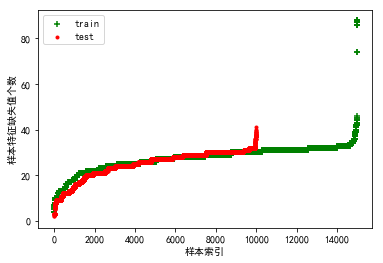

In [16]:
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
a = np.sum(data.loc[data.y != -1] == 0,axis=1)
a = a.sort_values()
b = np.sum(data.loc[data.y == -1] == 0,axis=1)
b = b.sort_values()
import matplotlib.pyplot as plt
plt.scatter(range(len(a)),a.values,color='g',marker='+',label='train')
plt.scatter(range(len(b)),b.values,color='r',marker='.',label='test')
plt.legend()
plt.xlabel('样本索引')
plt.ylabel('样本特征缺失值个数')
plt.show()

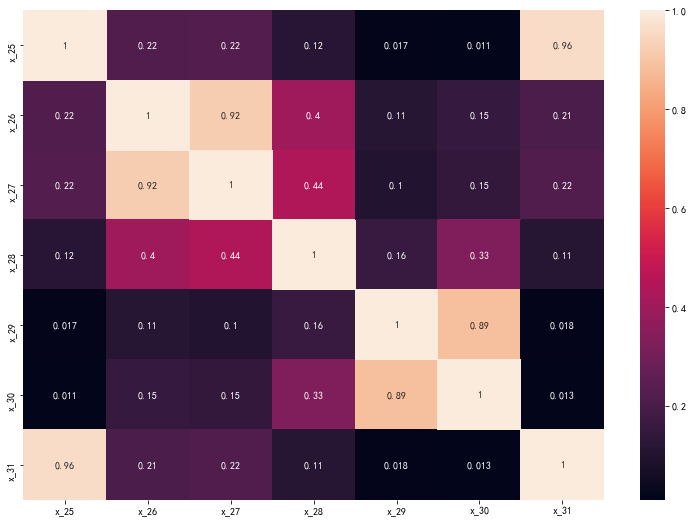

In [10]:
import seaborn as sns
cate_feature = [('x_'+str(i)) for i in range(96, 158) if ('x_'+str(i)) in data.columns]
num_feature = [('x_'+str(i)) for i in range(1, 96) if ('x_'+str(i)) in data.columns]+ ['x_99_100']
data_corr = data[num_feature].iloc[:,24:31].corr().abs()
plt.subplots(figsize=(13, 9))
sns.heatmap(data_corr,annot=True)

# Mask unimportant features
sns.heatmap(data_corr, mask=data_corr < 1, cbar=False)
plt.show()

In [11]:
total_feature = data.copy()  #拷贝副本

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
#分训练集测试集
train = data[data.y >= 0]
test = data[data.y == -1]
train_y = train.loc[:,'y'].values
#分特征
train_csr = total_feature[total_feature.y >= 0][num_feature+cate_feature]
predict_csr = total_feature[total_feature.y == -1][num_feature+cate_feature]
print('测试集shape', predict_csr.shape)

res = test.loc[:, ['cust_id']]
val_y = train.loc[:, ['cust_id']]   #这里val_y的作用是看符合题目评判标准的线下成绩
val_y['pred'] = 0

# 模型部分
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=4, learning_rate=0.05, n_estimators=4000,
                           max_bin=10, subsample_for_bin=10000, objective='binary', min_split_gain=0.405,
                           min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=5,
                           colsample_bytree=0.75, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=10, silent=True) 

# 五折交叉训练，构造五个模型
skf=list(StratifiedKFold(train_y, n_folds=5, shuffle=True, random_state=42))
baseauc = []
loss = 0
for i, (train_index, test_index) in enumerate(skf):
    print("Fold", i)
    lgb_model = model.fit(train_csr.iloc[train_index], train_y[train_index],
                          eval_names =['train','valid'],
                          eval_metric='auc',
                          eval_set=[(train_csr.iloc[train_index], train_y[train_index]), 
                                    (train_csr.iloc[test_index], train_y[test_index])],early_stopping_rounds=100)
    baseauc.append(lgb_model.best_score_['valid']['auc'])
    loss += lgb_model.best_score_['valid']['auc']
    
    train_pred= lgb_model.predict_proba(train_csr.iloc[test_index], num_iteration=lgb_model.best_iteration_)[:, 1]
    val_y.loc[val_y.cust_id.isin(val_y.iloc[test_index].cust_id.values), 'pred'] = train_pred
    
    test_pred= lgb_model.predict_proba(predict_csr, num_iteration=lgb_model.best_iteration_)[:, 1]
    print('test mean:', test_pred.mean())
    res['prob_%s' % str(i)] = test_pred
print('auc:', baseauc, sum(baseauc)/5)

测试集shape (10000, 121)
Fold 0
[1]	train's auc: 0.785179	train's binary_logloss: 0.184233	valid's auc: 0.727054	valid's binary_logloss: 0.18555
Training until validation scores don't improve for 100 rounds.
[2]	train's auc: 0.801088	train's binary_logloss: 0.182406	valid's auc: 0.746285	valid's binary_logloss: 0.184051
[3]	train's auc: 0.807626	train's binary_logloss: 0.180386	valid's auc: 0.748617	valid's binary_logloss: 0.182479
[4]	train's auc: 0.80806	train's binary_logloss: 0.178562	valid's auc: 0.747112	valid's binary_logloss: 0.181222
[5]	train's auc: 0.816969	train's binary_logloss: 0.177057	valid's auc: 0.753502	valid's binary_logloss: 0.180353
[6]	train's auc: 0.822514	train's binary_logloss: 0.175319	valid's auc: 0.75733	valid's binary_logloss: 0.179109
[7]	train's auc: 0.823691	train's binary_logloss: 0.173807	valid's auc: 0.75865	valid's binary_logloss: 0.178015
[8]	train's auc: 0.825594	train's binary_logloss: 0.172524	valid's auc: 0.761677	valid's binary_logloss: 0.176999


[81]	train's auc: 0.860244	train's binary_logloss: 0.1458	valid's auc: 0.792893	valid's binary_logloss: 0.161263
[82]	train's auc: 0.860505	train's binary_logloss: 0.14566	valid's auc: 0.793084	valid's binary_logloss: 0.161216
[83]	train's auc: 0.860816	train's binary_logloss: 0.145521	valid's auc: 0.793504	valid's binary_logloss: 0.161114
[84]	train's auc: 0.860975	train's binary_logloss: 0.145391	valid's auc: 0.793737	valid's binary_logloss: 0.161029
[85]	train's auc: 0.861135	train's binary_logloss: 0.145283	valid's auc: 0.79374	valid's binary_logloss: 0.160997
[86]	train's auc: 0.861372	train's binary_logloss: 0.145159	valid's auc: 0.793793	valid's binary_logloss: 0.160968
[87]	train's auc: 0.86167	train's binary_logloss: 0.145042	valid's auc: 0.79379	valid's binary_logloss: 0.160923
[88]	train's auc: 0.861889	train's binary_logloss: 0.144925	valid's auc: 0.794079	valid's binary_logloss: 0.160852
[89]	train's auc: 0.862111	train's binary_logloss: 0.144821	valid's auc: 0.794069	vali

[182]	train's auc: 0.884374	train's binary_logloss: 0.136848	valid's auc: 0.797694	valid's binary_logloss: 0.160068
[183]	train's auc: 0.88447	train's binary_logloss: 0.136777	valid's auc: 0.797779	valid's binary_logloss: 0.16005
[184]	train's auc: 0.884511	train's binary_logloss: 0.136721	valid's auc: 0.797742	valid's binary_logloss: 0.160048
[185]	train's auc: 0.884639	train's binary_logloss: 0.136676	valid's auc: 0.797842	valid's binary_logloss: 0.160029
[186]	train's auc: 0.88477	train's binary_logloss: 0.136632	valid's auc: 0.798101	valid's binary_logloss: 0.159962
[187]	train's auc: 0.884945	train's binary_logloss: 0.136579	valid's auc: 0.798531	valid's binary_logloss: 0.15985
[188]	train's auc: 0.885076	train's binary_logloss: 0.136539	valid's auc: 0.798584	valid's binary_logloss: 0.159803
[189]	train's auc: 0.885156	train's binary_logloss: 0.136509	valid's auc: 0.798926	valid's binary_logloss: 0.15975
[190]	train's auc: 0.885303	train's binary_logloss: 0.136453	valid's auc: 0.7

[276]	train's auc: 0.898733	train's binary_logloss: 0.131496	valid's auc: 0.799001	valid's binary_logloss: 0.160024
[277]	train's auc: 0.898859	train's binary_logloss: 0.131451	valid's auc: 0.798961	valid's binary_logloss: 0.160048
[278]	train's auc: 0.899076	train's binary_logloss: 0.131401	valid's auc: 0.798747	valid's binary_logloss: 0.160079
[279]	train's auc: 0.89922	train's binary_logloss: 0.13135	valid's auc: 0.798629	valid's binary_logloss: 0.160102
[280]	train's auc: 0.899288	train's binary_logloss: 0.131312	valid's auc: 0.798516	valid's binary_logloss: 0.160141
[281]	train's auc: 0.899376	train's binary_logloss: 0.131277	valid's auc: 0.798679	valid's binary_logloss: 0.160128
[282]	train's auc: 0.899499	train's binary_logloss: 0.131239	valid's auc: 0.798843	valid's binary_logloss: 0.16009
[283]	train's auc: 0.899628	train's binary_logloss: 0.131198	valid's auc: 0.799114	valid's binary_logloss: 0.160065
[284]	train's auc: 0.899808	train's binary_logloss: 0.131141	valid's auc: 0

[59]	train's auc: 0.850827	train's binary_logloss: 0.150145	valid's auc: 0.814741	valid's binary_logloss: 0.157589
[60]	train's auc: 0.851381	train's binary_logloss: 0.149918	valid's auc: 0.815012	valid's binary_logloss: 0.157439
[61]	train's auc: 0.851769	train's binary_logloss: 0.149722	valid's auc: 0.814977	valid's binary_logloss: 0.157366
[62]	train's auc: 0.852341	train's binary_logloss: 0.149511	valid's auc: 0.814838	valid's binary_logloss: 0.157333
[63]	train's auc: 0.852849	train's binary_logloss: 0.14933	valid's auc: 0.814665	valid's binary_logloss: 0.157332
[64]	train's auc: 0.853211	train's binary_logloss: 0.149153	valid's auc: 0.814493	valid's binary_logloss: 0.157287
[65]	train's auc: 0.853656	train's binary_logloss: 0.14897	valid's auc: 0.814655	valid's binary_logloss: 0.157254
[66]	train's auc: 0.854163	train's binary_logloss: 0.148749	valid's auc: 0.81462	valid's binary_logloss: 0.157192
[67]	train's auc: 0.854667	train's binary_logloss: 0.148533	valid's auc: 0.814579	v

[161]	train's auc: 0.882876	train's binary_logloss: 0.137589	valid's auc: 0.814344	valid's binary_logloss: 0.157033
[162]	train's auc: 0.883209	train's binary_logloss: 0.137489	valid's auc: 0.814078	valid's binary_logloss: 0.157051
[163]	train's auc: 0.883543	train's binary_logloss: 0.137389	valid's auc: 0.813741	valid's binary_logloss: 0.157116
[164]	train's auc: 0.883929	train's binary_logloss: 0.137296	valid's auc: 0.813691	valid's binary_logloss: 0.15714
[165]	train's auc: 0.884151	train's binary_logloss: 0.137233	valid's auc: 0.813265	valid's binary_logloss: 0.15724
[166]	train's auc: 0.88444	train's binary_logloss: 0.137156	valid's auc: 0.813134	valid's binary_logloss: 0.157289
[167]	train's auc: 0.884712	train's binary_logloss: 0.137076	valid's auc: 0.813022	valid's binary_logloss: 0.15732
[168]	train's auc: 0.884946	train's binary_logloss: 0.136996	valid's auc: 0.812911	valid's binary_logloss: 0.157369
[169]	train's auc: 0.885013	train's binary_logloss: 0.136945	valid's auc: 0.

[66]	train's auc: 0.849731	train's binary_logloss: 0.149056	valid's auc: 0.821702	valid's binary_logloss: 0.156198
[67]	train's auc: 0.850025	train's binary_logloss: 0.148912	valid's auc: 0.821773	valid's binary_logloss: 0.156155
[68]	train's auc: 0.850448	train's binary_logloss: 0.148771	valid's auc: 0.82195	valid's binary_logloss: 0.156137
[69]	train's auc: 0.850802	train's binary_logloss: 0.148657	valid's auc: 0.822213	valid's binary_logloss: 0.156061
[70]	train's auc: 0.85096	train's binary_logloss: 0.148536	valid's auc: 0.822357	valid's binary_logloss: 0.155986
[71]	train's auc: 0.851251	train's binary_logloss: 0.148364	valid's auc: 0.822563	valid's binary_logloss: 0.155879
[72]	train's auc: 0.85156	train's binary_logloss: 0.148232	valid's auc: 0.823089	valid's binary_logloss: 0.155759
[73]	train's auc: 0.851796	train's binary_logloss: 0.148082	valid's auc: 0.823208	valid's binary_logloss: 0.155671
[74]	train's auc: 0.852048	train's binary_logloss: 0.147941	valid's auc: 0.823527	v

[168]	train's auc: 0.879407	train's binary_logloss: 0.138651	valid's auc: 0.833895	valid's binary_logloss: 0.152174
[169]	train's auc: 0.879545	train's binary_logloss: 0.138602	valid's auc: 0.834037	valid's binary_logloss: 0.152114
[170]	train's auc: 0.879725	train's binary_logloss: 0.138546	valid's auc: 0.834197	valid's binary_logloss: 0.152102
[171]	train's auc: 0.879971	train's binary_logloss: 0.138454	valid's auc: 0.83428	valid's binary_logloss: 0.152033
[172]	train's auc: 0.880239	train's binary_logloss: 0.13836	valid's auc: 0.834468	valid's binary_logloss: 0.151998
[173]	train's auc: 0.88042	train's binary_logloss: 0.138277	valid's auc: 0.834546	valid's binary_logloss: 0.151963
[174]	train's auc: 0.880607	train's binary_logloss: 0.138206	valid's auc: 0.834637	valid's binary_logloss: 0.151919
[175]	train's auc: 0.880893	train's binary_logloss: 0.13815	valid's auc: 0.834764	valid's binary_logloss: 0.151868
[176]	train's auc: 0.881071	train's binary_logloss: 0.138091	valid's auc: 0.

[242]	train's auc: 0.892843	train's binary_logloss: 0.134221	valid's auc: 0.834088	valid's binary_logloss: 0.152057
[243]	train's auc: 0.892943	train's binary_logloss: 0.134183	valid's auc: 0.834103	valid's binary_logloss: 0.152032
[244]	train's auc: 0.893065	train's binary_logloss: 0.13414	valid's auc: 0.833987	valid's binary_logloss: 0.152073
[245]	train's auc: 0.893247	train's binary_logloss: 0.134078	valid's auc: 0.833885	valid's binary_logloss: 0.152096
[246]	train's auc: 0.893284	train's binary_logloss: 0.134043	valid's auc: 0.833969	valid's binary_logloss: 0.152087
[247]	train's auc: 0.893292	train's binary_logloss: 0.134011	valid's auc: 0.833984	valid's binary_logloss: 0.15208
[248]	train's auc: 0.893306	train's binary_logloss: 0.133977	valid's auc: 0.834144	valid's binary_logloss: 0.152052
[249]	train's auc: 0.893343	train's binary_logloss: 0.133951	valid's auc: 0.834103	valid's binary_logloss: 0.152036
[250]	train's auc: 0.893361	train's binary_logloss: 0.13392	valid's auc: 0

[34]	train's auc: 0.839983	train's binary_logloss: 0.155781	valid's auc: 0.804923	valid's binary_logloss: 0.160898
[35]	train's auc: 0.840813	train's binary_logloss: 0.155408	valid's auc: 0.805105	valid's binary_logloss: 0.160739
[36]	train's auc: 0.841027	train's binary_logloss: 0.1551	valid's auc: 0.805342	valid's binary_logloss: 0.16053
[37]	train's auc: 0.841115	train's binary_logloss: 0.154815	valid's auc: 0.805471	valid's binary_logloss: 0.160341
[38]	train's auc: 0.841665	train's binary_logloss: 0.154494	valid's auc: 0.805154	valid's binary_logloss: 0.160247
[39]	train's auc: 0.841945	train's binary_logloss: 0.154241	valid's auc: 0.805157	valid's binary_logloss: 0.160094
[40]	train's auc: 0.841965	train's binary_logloss: 0.153971	valid's auc: 0.805159	valid's binary_logloss: 0.159914
[41]	train's auc: 0.842317	train's binary_logloss: 0.153666	valid's auc: 0.804948	valid's binary_logloss: 0.159824
[42]	train's auc: 0.842596	train's binary_logloss: 0.153437	valid's auc: 0.805904	v

[137]	train's auc: 0.874046	train's binary_logloss: 0.140391	valid's auc: 0.82753	valid's binary_logloss: 0.153592
[138]	train's auc: 0.874205	train's binary_logloss: 0.140335	valid's auc: 0.827735	valid's binary_logloss: 0.153549
[139]	train's auc: 0.874445	train's binary_logloss: 0.140262	valid's auc: 0.82748	valid's binary_logloss: 0.153572
[140]	train's auc: 0.874699	train's binary_logloss: 0.140204	valid's auc: 0.827642	valid's binary_logloss: 0.153571
[141]	train's auc: 0.875121	train's binary_logloss: 0.140104	valid's auc: 0.828052	valid's binary_logloss: 0.153472
[142]	train's auc: 0.875395	train's binary_logloss: 0.140056	valid's auc: 0.828264	valid's binary_logloss: 0.153428
[143]	train's auc: 0.87571	train's binary_logloss: 0.13995	valid's auc: 0.828237	valid's binary_logloss: 0.153407
[144]	train's auc: 0.876041	train's binary_logloss: 0.139875	valid's auc: 0.828361	valid's binary_logloss: 0.153396
[145]	train's auc: 0.876195	train's binary_logloss: 0.139836	valid's auc: 0.

[212]	train's auc: 0.888902	train's binary_logloss: 0.135245	valid's auc: 0.833078	valid's binary_logloss: 0.152567
[213]	train's auc: 0.889048	train's binary_logloss: 0.135198	valid's auc: 0.832941	valid's binary_logloss: 0.152617
[214]	train's auc: 0.889131	train's binary_logloss: 0.135168	valid's auc: 0.83285	valid's binary_logloss: 0.152648
[215]	train's auc: 0.889193	train's binary_logloss: 0.135126	valid's auc: 0.832726	valid's binary_logloss: 0.152678
[216]	train's auc: 0.889203	train's binary_logloss: 0.135077	valid's auc: 0.832602	valid's binary_logloss: 0.15272
[217]	train's auc: 0.889274	train's binary_logloss: 0.135016	valid's auc: 0.832452	valid's binary_logloss: 0.152764
[218]	train's auc: 0.889436	train's binary_logloss: 0.134927	valid's auc: 0.832303	valid's binary_logloss: 0.152791
[219]	train's auc: 0.889483	train's binary_logloss: 0.134864	valid's auc: 0.832255	valid's binary_logloss: 0.152825
[220]	train's auc: 0.889611	train's binary_logloss: 0.134791	valid's auc: 

test mean: 0.02836531802539551
Fold 4
[1]	train's auc: 0.77746	train's binary_logloss: 0.184336	valid's auc: 0.72941	valid's binary_logloss: 0.185052
Training until validation scores don't improve for 100 rounds.
[2]	train's auc: 0.800643	train's binary_logloss: 0.18222	valid's auc: 0.754193	valid's binary_logloss: 0.183348
[3]	train's auc: 0.805479	train's binary_logloss: 0.179987	valid's auc: 0.758537	valid's binary_logloss: 0.181864
[4]	train's auc: 0.807049	train's binary_logloss: 0.1781	valid's auc: 0.76381	valid's binary_logloss: 0.180399
[5]	train's auc: 0.810455	train's binary_logloss: 0.176528	valid's auc: 0.76878	valid's binary_logloss: 0.179187
[6]	train's auc: 0.812917	train's binary_logloss: 0.174937	valid's auc: 0.775321	valid's binary_logloss: 0.177884
[7]	train's auc: 0.815201	train's binary_logloss: 0.173468	valid's auc: 0.775409	valid's binary_logloss: 0.17677
[8]	train's auc: 0.818404	train's binary_logloss: 0.172282	valid's auc: 0.777729	valid's binary_logloss: 0.17

[101]	train's auc: 0.865258	train's binary_logloss: 0.143531	valid's auc: 0.811381	valid's binary_logloss: 0.157483
[102]	train's auc: 0.865578	train's binary_logloss: 0.143431	valid's auc: 0.811343	valid's binary_logloss: 0.157487
[103]	train's auc: 0.865958	train's binary_logloss: 0.143314	valid's auc: 0.811475	valid's binary_logloss: 0.157453
[104]	train's auc: 0.86631	train's binary_logloss: 0.143211	valid's auc: 0.811255	valid's binary_logloss: 0.157486
[105]	train's auc: 0.866607	train's binary_logloss: 0.143125	valid's auc: 0.811399	valid's binary_logloss: 0.157461
[106]	train's auc: 0.867027	train's binary_logloss: 0.142985	valid's auc: 0.810728	valid's binary_logloss: 0.157573
[107]	train's auc: 0.86754	train's binary_logloss: 0.142831	valid's auc: 0.810214	valid's binary_logloss: 0.157658
[108]	train's auc: 0.868	train's binary_logloss: 0.142707	valid's auc: 0.809993	valid's binary_logloss: 0.157731
[109]	train's auc: 0.868345	train's binary_logloss: 0.14261	valid's auc: 0.80

[191]	train's auc: 0.886125	train's binary_logloss: 0.135754	valid's auc: 0.806939	valid's binary_logloss: 0.158572
[192]	train's auc: 0.886388	train's binary_logloss: 0.135649	valid's auc: 0.806883	valid's binary_logloss: 0.158589
[193]	train's auc: 0.886672	train's binary_logloss: 0.135555	valid's auc: 0.806982	valid's binary_logloss: 0.158583
[194]	train's auc: 0.886827	train's binary_logloss: 0.135455	valid's auc: 0.806911	valid's binary_logloss: 0.15862
[195]	train's auc: 0.887052	train's binary_logloss: 0.135367	valid's auc: 0.806572	valid's binary_logloss: 0.158714
[196]	train's auc: 0.887247	train's binary_logloss: 0.135294	valid's auc: 0.806886	valid's binary_logloss: 0.158666
[197]	train's auc: 0.887269	train's binary_logloss: 0.135243	valid's auc: 0.806979	valid's binary_logloss: 0.158653
[198]	train's auc: 0.887518	train's binary_logloss: 0.135176	valid's auc: 0.80704	valid's binary_logloss: 0.158637
[199]	train's auc: 0.887611	train's binary_logloss: 0.135137	valid's auc: 

In [13]:
from sklearn.metrics import roc_auc_score
def auc_3_cust(res):
#     res = pd.DataFrame()
#     res['cust_group'] = data[data.y >= 0].cust_group
#     res['y'] = y_true
#     res['pred'] = y_pred
    df = res.copy()
    a1 = df[df.cust_group == 'group_1']
    a2 = df[df.cust_group == 'group_2']
    a3 = df[df.cust_group == 'group_3']
    auc1 = roc_auc_score(a1.y, a1.pred)
    auc2 = roc_auc_score(a2.y, a2.pred)
    auc3 = roc_auc_score(a3.y, a3.pred)
    return 0.3*auc1 + 0.3*auc2 + 0.4*auc3

In [14]:
val_y = pd.merge(val_y, train[['cust_id', 'cust_group', 'y']], on = 'cust_id', how = 'left')
print('线下auc结果：', auc_3_cust(val_y))

线下auc结果： 0.7907619233558733


In [25]:
data.columns

Index(['cust_group', 'cust_id', 'x_1', 'x_10', 'x_100', 'x_101', 'x_11',
       'x_12', 'x_13', 'x_139',
       ...
       'x_92', 'x_93', 'x_94', 'x_95', 'x_96', 'x_97', 'x_98', 'x_99', 'y',
       'x_99_100'],
      dtype='object', length=124)

In [26]:
fea = pd.DataFrame()
fea['fea'] = data.columns[2:-2].tolist() + ['x_99_100']
fea['ip'] = lgb_model.feature_importances_
fea.loc[fea.ip != 0].sort_values('ip', ascending=False)

,fea,ip
79,x_62,77
51,x_37,44
120,x_99_100,31
103,x_84,29
61,x_46,29
62,x_47,28
94,x_76,25
47,x_33,22
56,x_41,22
13,x_144,21


In [15]:
# import datetime
# # # 简单平均5折结果
# res['pred_prob'] = 0
# for i in range(5):
#     res['pred_prob'] += res['prob_%s' % str(i)]
# res['pred_prob'] /= 5

# # 提交结果
# mean = res['pred_prob'].mean()
# print('mean:',mean)
# now = datetime.datetime.now()
# now = now.strftime('%m-%d-%H-%M')
# res[['cust_id', 'pred_prob']].to_csv("pred/lgb_baseline_%f_%s.csv" % (round(auc_3_cust(val_y), 4), now), index=False)